In [1]:
# imports

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from barnacle import visualize_3d_tensor, plot_factors_heatmap
from pathlib import Path
from sklearn.model_selection import ParameterGrid
import statsmodels.api as sm
import tensorly as tl
from tlab.cp_tensor import load_cp_tensor
import tlviz
from tlviz.factor_tools import factor_match_score, cosine_similarity
from tlviz.model_evaluation import relative_sse
import xarray as xr
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mpl.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF', '#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
# custom continuous cmap 
grad_hexes = ['#9B5DE5', '#FFAC69']
grad_cmap = get_continuous_cmap(grad_hexes)

# keywargs for annotating panels
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


# Collect data

In [31]:
# look at data

data_dir = Path('../../data/1-simulation/archive/')
out_dir = Path('../../figures/1-simulation/')
results_df = pd.read_csv(data_dir / 'cv_data.csv')

results_df


,simulation_id,simulation_rank,simulation_shape,simulation_densities,simulation_mean_gene_sparsity,noise_level,rank,lambda,modeled_replicate,comparison_replicate,...,model_fms,true_fms,model_factor0_cosine_similarity,true_factor0_cosine_similarity,model_factor0_support_cosine_similarity,true_factor0_support_cosine_similarity,recovery,relevance,precision,recall
0,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,A,...,NaN,0.968409,NaN,0.976258,NaN,0.863145,0.745020,0.733815,0.996628,0.270695
1,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,B,...,0.998166,NaN,0.998288,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
2,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,A,C,...,0.998503,NaN,0.998615,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
3,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,8,"(502, 24, 45)","[0.7338183385355674, 0.4477836417936504, 0.055...",368.376806,0.302524,1,0.0,B,B,...,NaN,0.969926,NaN,0.977179,NaN,0.863145,0.745020,0.733815,0.996628,0.270695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107995,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,B,B,...,NaN,0.037424,NaN,0.077594,NaN,0.050306,0.001616,0.003607,1.000000,0.000002
107996,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,B,C,...,0.026481,NaN,0.102243,NaN,0.131446,NaN,NaN,NaN,NaN,NaN
107997,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,C,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107998,99,4,"(633, 20, 72)","[0.7624442923315047, 0.2901681737242643, 0.475...",482.627237,7.181685,12,12.8,C,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# separate out a dataframe of summary simulation information

# pull out simulation information
simulation_info_df = results_df[
    [
        'simulation_id', 
        'simulation_rank', 
        'simulation_shape', 
        'simulation_densities', 
        'simulation_mean_gene_sparsity', 
        'noise_level'
    ]
].drop_duplicates().reset_index(drop=True)
# separate out shape densities
simulation_info_df['mode0_length'] = [int(i[0]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode1_length'] = [int(i[1]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
simulation_info_df['mode2_length'] = [int(i[2]) for i in simulation_info_df['simulation_shape'].str[1:-1].str.split(', ')]
# separate out factor densities
simulation_info_df['factor0_density'] = [float(i[0]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor1_density'] = [float(i[1]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df['factor2_density'] = [float(i[2]) for i in simulation_info_df['simulation_densities'].str[1:-1].str.split(', ')]
simulation_info_df.drop(columns='simulation_densities', inplace=True)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,0.172216
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,0.785242
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,0.629525
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,0.445537
...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,0.688076
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,0.054712
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,0.222218


In [6]:
# separate out ground truth data 
# compares models against simulation ground truth

gt_df = results_df[results_df['modeled_replicate'] == results_df['comparison_replicate']]
gt_df = gt_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'n_components', 'mean_gene_sparsity', 'relative_sse', 
    'true_fms', 'recovery', 'relevance', 'precision', 'recall'
]].reset_index(drop=True)
# derived metrics
gt_df['f1'] = (2 * gt_df['precision'] * gt_df['recall']) / (gt_df['precision'] + gt_df['recall'])

# generate separate dataframe for aggregated metrics
gt_df_agg = gt_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    gt_sse_mean=('relative_sse', 'mean'), 
    gt_fms_mean=('true_fms', 'mean'), 
    gt_recovery_mean=('recovery', 'mean'), 
    gt_relevance_mean=('relevance', 'mean'), 
    gt_precision_mean=('precision', 'mean'), 
    gt_recall_mean=('recall', 'mean'), 
    gt_f1_mean=('f1', 'mean')
).reset_index()

gt_df_agg


,simulation_id,rank,lambda,gt_sse_mean,gt_fms_mean,gt_recovery_mean,gt_relevance_mean,gt_precision_mean,gt_recall_mean,gt_f1_mean
0,0,1,0.00,0.735901,0.969171,0.745020,0.733815,0.996628,0.270695,0.425752
1,0,1,0.05,0.735984,0.970011,0.755146,0.720852,0.997566,0.238764,0.385293
2,0,1,0.10,0.736225,0.970759,0.762470,0.709512,0.998171,0.218749,0.358844
3,0,1,0.20,0.737150,0.971796,0.776318,0.688529,0.998335,0.192815,0.323205
4,0,1,0.40,0.740531,0.972065,0.784032,0.645270,0.998758,0.150848,0.262096
...,...,...,...,...,...,...,...,...,...,...
11995,99,12,0.80,0.956627,0.708852,0.683542,0.750353,0.381388,0.998530,0.551809
11996,99,12,1.60,0.961775,0.598320,0.563823,0.629176,0.737336,0.898814,0.809882
11997,99,12,3.20,0.971610,0.476196,0.325723,0.371192,0.983404,0.333843,0.498429
11998,99,12,6.40,0.985889,0.247152,0.102244,0.159379,0.999264,0.034346,0.066404


In [7]:
# separate out cross validation data
# compares each model fit to one replicate against models fit to the other two replicates

cv_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
cv_df = cv_df[[
    'simulation_id', 'rank', 'lambda', 'modeled_replicate', 'comparison_replicate', 
    'replicate_pair', 'n_components', 'mean_gene_sparsity', 'relative_sse', 'model_fms'
]].reset_index(drop=True)

# generate separate dataframe for aggregated metrics
cv_df_agg = cv_df.groupby([
    'simulation_id', 
    'rank', 
    'lambda'
]).agg(
    cv_sse_mean=('relative_sse', 'mean'), 
    cv_sse_sem=('relative_sse', 'sem'), 
    cv_fms_mean=('model_fms', 'mean'), 
    cv_fms_sem=('model_fms', 'sem'), 
).reset_index()

cv_df_agg


,simulation_id,rank,lambda,cv_sse_mean,cv_sse_sem,cv_fms_mean,cv_fms_sem
0,0,1,0.00,0.736795,0.000476,0.998302,0.000103
1,0,1,0.05,0.736867,0.000466,0.998290,0.000106
2,0,1,0.10,0.737093,0.000457,0.998283,0.000105
3,0,1,0.20,0.737988,0.000437,0.998250,0.000105
4,0,1,0.40,0.741327,0.000401,0.998122,0.000111
...,...,...,...,...,...,...,...
11995,99,12,0.80,0.999966,0.000286,0.191279,0.005289
11996,99,12,1.60,0.994789,0.000239,0.174680,0.005152
11997,99,12,3.20,0.991354,0.000129,0.169882,0.005800
11998,99,12,6.40,0.994599,0.000080,0.111894,0.002197


# Estimating optimal sparsity

Unlike the R parameter which is used both in generating simulations and fitting models to data, the lambda parameter is not used to generate simulations and is only used to parameterize model fitting. Therefore there is no ground truth optimal lambda encoded in the simulated data.

Instread, ground truth optimal sparsity must be estimated. Here we estimate ground truth lambda by looking at cluster membership metrics, comparing the subset of models fit with the correct number of components against the simulation ground truth. The lambda corresponding to the maximum F1 score is used as the estimated ground truth optimal sparsity


In [10]:
# estimate ground truth optimal lambda based on F1 score

# set up dataframe for selecting best lambda
gt_lambda_df = gt_df_agg.copy()
gt_lambda_df['simulation_rank'] = gt_lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['simulation_rank']
)
# down-select to only models that were fit with the true number of components
gt_lambda_df = gt_lambda_df[gt_lambda_df['rank'] == gt_lambda_df['simulation_rank']].reset_index(drop=True)
# sort by descending lambda value so that if there is a tie in the score, the highest lambda value is picked
gt_lambda_df = gt_lambda_df.sort_values(['simulation_id', 'lambda'], ascending=False)

# identify the lambda corresponding to the max F1 score
gt_lambda_df = gt_lambda_df.loc[gt_lambda_df.groupby('simulation_id')['gt_f1_mean'].idxmax(), :].reset_index()

# add estimated ground truth optimal lambda to simulation info df
simulation_info_df['gt_lambda'] = simulation_info_df['simulation_id'].map(
    gt_lambda_df.set_index('simulation_id')['lambda']
)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,gt_lambda
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101,0.1
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,0.172216,0.2
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,0.785242,0.8
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,0.629525,0.8
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,0.445537,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075,0.0
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,0.688076,3.2
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,0.054712,0.8
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,0.222218,0.1


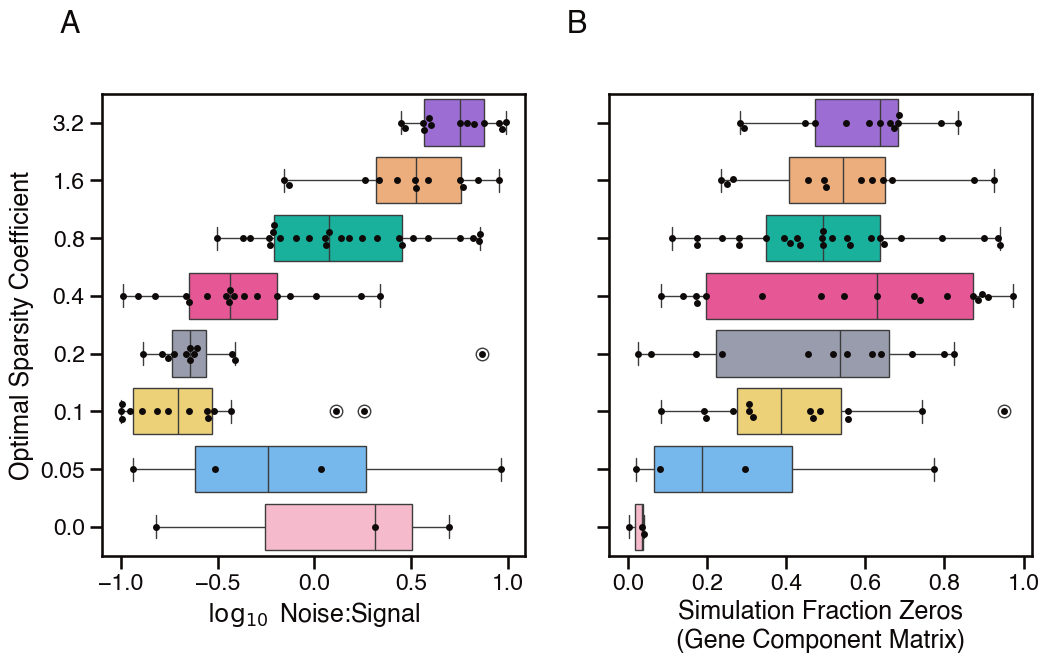

In [37]:
# plot optimal lambda by noise and simulation zeros

# curate data
plot_df = simulation_info_df
plot_df['true_sparsity'] = (1 - plot_df['factor0_density'])
plot_df['log_noise'] = np.log10(plot_df['noise_level'])

# plot figure
fig, axis = plt.subplots(1, 2, figsize=[12, 6], sharey=True)
for i, var in enumerate(['log_noise', 'true_sparsity']):
    sns.boxplot(
        x=var, 
        y='gt_lambda', 
        data=plot_df, 
        ax=axis[i], 
        palette=[accent_colors[i] for i in [0, 1, 2, 3, 5, 6, 7, 8]], 
        orient='h', 
        order = np.flip(np.sort(plot_df.gt_lambda.unique()))
    )
    sns.swarmplot(
        x=var, 
        y='gt_lambda', 
        data=plot_df, 
        ax=axis[i], 
        color=accent_colors[4], 
        orient='h', 
        order = np.flip(np.sort(plot_df.gt_lambda.unique()))
    )
    axis[i].annotate({0: 'A', 1: 'B'}[i], xy=(-0.1, 1.15), **annot_kwgs)
    axis[i].set_xlabel({
        'log_noise': '$\log_{10}$ Noise:Signal', 
        'true_sparsity': 'Simulation Fraction Zeros\n(Gene Component Matrix)'
    }[var])
    if not i:
        axis[i].set_ylabel('Optimal Sparsity Coefficient')
    
# plt.subplots_adjust(wspace=0.3)
plt.savefig(out_dir / 'estimating-optimal-lambda.png', bbox_inches='tight')


# Summarizing Accuracy of Optimal Models

Summary of simulated data experiments

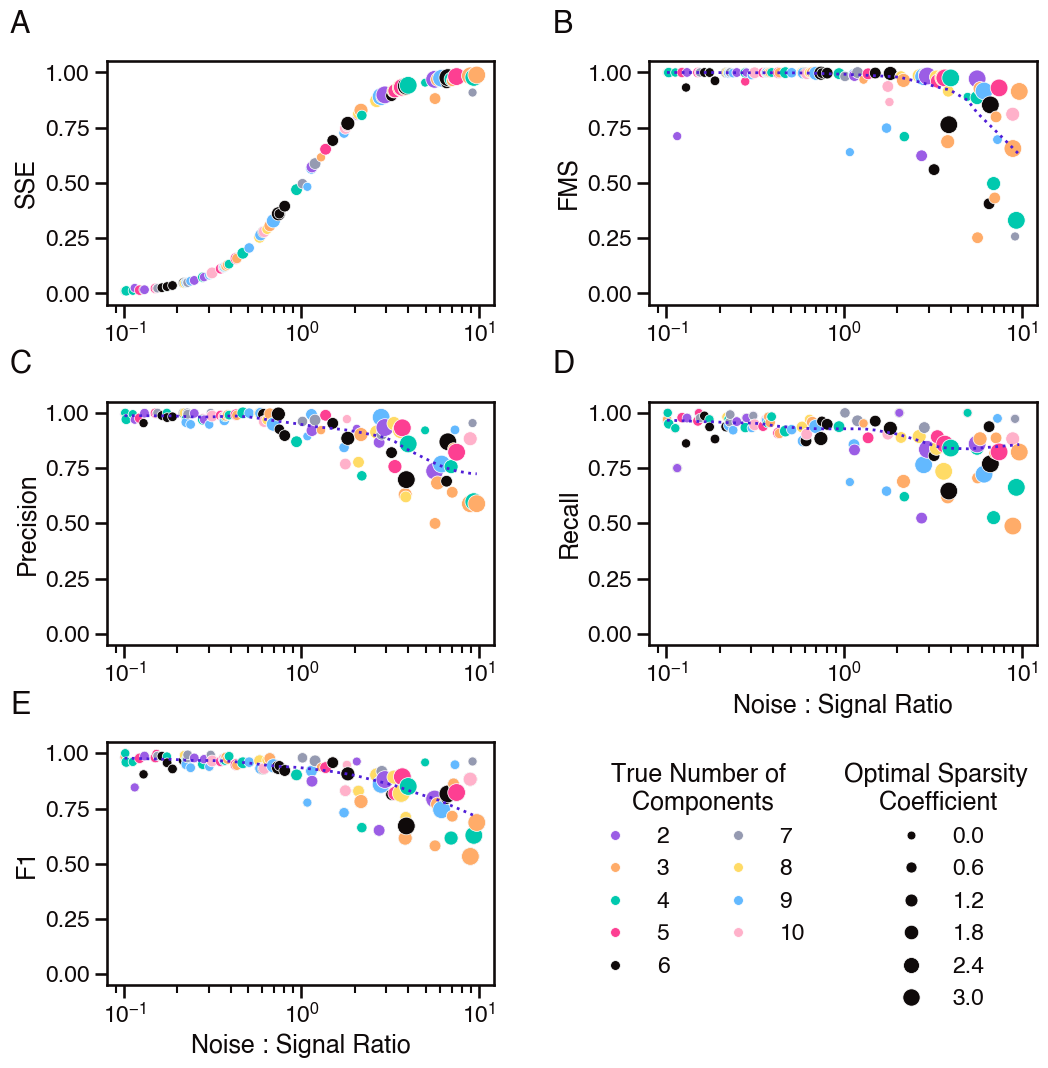

In [163]:
# plot metric differences of models parameterized with best fit and optimal lambda values

# make figure panel
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(3, 2, figure=fig, hspace=0.4, wspace=0.4)

# set up data
plot_df = pd.merge(
    simulation_info_df, 
    gt_df_agg, 
    left_on=['simulation_id', 'simulation_rank', 'gt_lambda'], 
    right_on=['simulation_id', 'rank', 'lambda'], 
    how='left'
)

# fix rank labels
plot_df['components'] = plot_df['simulation_rank'].astype('str')
plot_df = plot_df.sort_values('noise_level')

# plot each metric
metrics = ['gt_sse_mean', 'gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_f1_mean']
for i, metric in enumerate(metrics):
    # make new axis
    axis = fig.add_subplot(gs[(i // 2), (i % 2)])
    axis.annotate({0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E'}[i], xy=(-0.25, 1.15), **annot_kwgs)
    # make legends
    if i == 3:
        sns.scatterplot(x=ind_var, y=metric, hue='components', s=50, data=summary_df, ax=axis, legend=True)
        axis.legend(title='True Number of\n   Components', loc='upper left', ncol=2, bbox_to_anchor=(-0.2, -0.4))
    if i == 4:
        sns.scatterplot(x=ind_var, y=metric, size='gt_lambda', color=accent_colors[4], data=summary_df, ax=axis, legend=True)
        axis.legend(title='Optimal Sparsity\n     Coefficient', loc='upper left', bbox_to_anchor=(1.85, 1))
    # plot data
    sns.scatterplot(
        x='noise_level', y=metric, hue='components', size='gt_lambda', data=plot_df, ax=axis, legend=False
    )
    # plot LOWESS smoothed line
    if i:
        smoothed_line = sm.nonparametric.lowess(plot_df[metric], plot_df['log_noise'], frac = 0.3)
        sns.lineplot(x=plot_df['noise_level'], y=smoothed_line[:, 1], color=accent_colors[9], linestyle=':', legend=False)
    # fix labels
    if i > 2:
        axis.set(ylabel=labels[metric], xlabel='Noise : Signal Ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])

plt.savefig(out_dir / 'simulation-optimal-model-summary.png', bbox_inches='tight')


In [121]:
# look at statistics of optimal models

summary_df.describe()

,simulation_id,simulation_rank,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,...,selected_rank,rank,lambda,gt_sse_mean,gt_fms_mean,gt_recovery_mean,gt_relevance_mean,gt_precision_mean,gt_recall_mean,gt_f1_mean
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,6.220000,289.676088,2.190888,542.190000,50.890000,55.640000,0.509863,0.551759,0.519539,...,6.030000,6.220000,0.916000,0.473765,0.910208,0.870583,0.861317,0.906014,0.884160,0.891455
std,29.011492,2.572504,234.802607,2.647171,293.955047,26.039944,25.675331,0.263503,0.255004,0.282503,...,2.575938,2.572504,1.001435,0.390220,0.172167,0.134737,0.144497,0.119177,0.114501,0.110081
min,0.000000,2.000000,5.093007,0.100814,41.000000,10.000000,10.000000,0.026889,0.026430,0.011921,...,1.000000,2.000000,0.000000,0.010290,0.252268,0.444594,0.452484,0.499758,0.487974,0.533311
25%,24.750000,4.000000,83.487368,0.278132,266.250000,26.750000,33.000000,0.325250,0.346008,0.304022,...,4.000000,4.000000,0.200000,0.073488,0.924361,0.791377,0.774339,0.869336,0.840552,0.830205
50%,49.500000,6.000000,220.984717,0.777711,563.000000,52.000000,60.500000,0.505111,0.560903,0.493047,...,6.000000,6.000000,0.600000,0.377948,0.994319,0.930903,0.927905,0.959028,0.930395,0.937897
75%,74.250000,8.250000,446.913818,3.326509,785.000000,74.500000,78.000000,0.722822,0.765765,0.721259,...,8.000000,8.250000,1.000000,0.901192,0.999402,0.969121,0.966850,0.990232,0.963432,0.966840
max,99.000000,10.000000,901.747505,9.701963,1000.000000,98.000000,98.000000,0.997828,0.952523,0.994258,...,10.000000,10.000000,3.200000,0.988433,0.999980,1.000000,1.000000,1.000000,1.000000,1.000000


# Selecting model rank

In model fitting, model rank is selected as the rank of the model with the minimum cross-validated SSE value

In [40]:
# find the optimal rank parameter for each simulation based on minimum CV SSE

rank_optima_df = cv_df.copy()
# select the sse minimum for each simulation
rank_optima_df = rank_optima_df.loc[rank_optima_df.groupby('simulation_id').relative_sse.idxmin(), :]
# map optimal rank back to simulation_info_df
rank_optima = rank_optima_df.set_index('simulation_id')['rank']
simulation_info_df['selected_rank'] = simulation_info_df['simulation_id'].map(rank_optima)

simulation_info_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,gt_lambda,true_sparsity,log_noise,optimal_rank,selected_rank
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,0.055101,0.1,0.266182,-0.519240,8,8
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,0.172216,0.2,0.617592,-0.624195,8,8
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,0.785242,0.8,0.636897,0.587226,3,3
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,0.629525,0.8,0.553534,-0.178434,4,4
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,0.445537,1.6,0.496828,0.766355,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075,0.0,0.002172,-0.816981,9,9
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,0.688076,3.2,0.672147,0.970298,1,1
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,0.054712,0.8,0.490676,0.507049,7,7
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,0.222218,0.1,0.317392,-0.649595,5,5


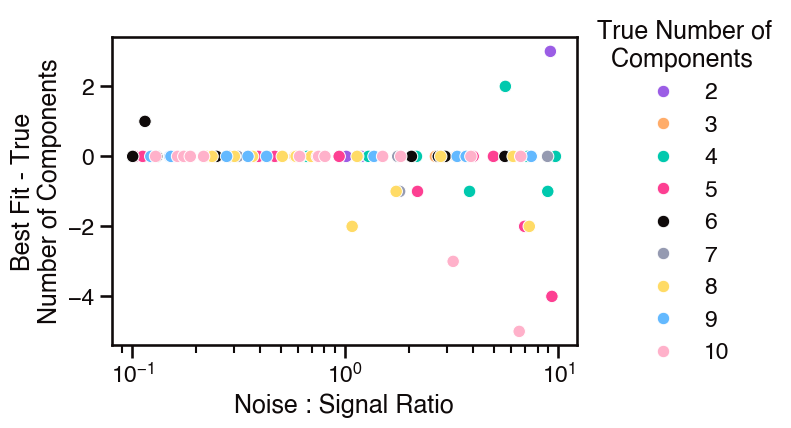

In [41]:
# plot true rank vs. optimal rank

# arrange data for plotting
rank_plot_df = simulation_info_df.copy()
rank_plot_df['min_cv_sse'] = rank_plot_df['simulation_id'].map(
    rank_optima_df.set_index('simulation_id')['relative_sse']
)
rank_plot_df['rank_difference'] = rank_plot_df['selected_rank'] - rank_plot_df['simulation_rank']
rank_plot_df = rank_plot_df.sort_values(['simulation_rank', 'noise_level']).reset_index(drop=True)
rank_plot_df['simulation_rank'] = rank_plot_df['simulation_rank'].astype(str)

# create plot
fig_1a, ax_1a = plt.subplots(figsize=[6, 4])
sns.scatterplot(
    x='noise_level', 
    y='rank_difference', 
    hue='simulation_rank', 
    alpha=1.0, 
    data=rank_plot_df, 
    ax=ax_1a
)
plt.xlabel('Noise : Signal Ratio');
plt.ylabel('Best Fit - True\nNumber of Components');
plt.xscale('log')
plt.legend(title='True Number of\n  Components', loc='center left', bbox_to_anchor=[1, .5]);
# plt.savefig('optimal_rank_v_noise.png', bbox_inches='tight')


# Compare methods of picking optimal sparsity

Within the optimal rank, find lambda corresponding to:
* Minimum of cross-validated SSE
* Inflection point of cross-validated SSE (maximum change in slope)
* Maximum of cross-validated FMS
* Inflection point of cross-validated FMS (minimum change in slope)
* Maximum lambda within 1 standard error of minimum cross-validated SSE 
* Maximum lambda within 1 standard error of maximum cross-validated FMS 

Score as sum of absolute values of difference between log(selected lambda) and log(optimal lambda)


In [15]:
# find optima of different selection criteria based on cross-validated scoring metrics

# set up dataframe for selecting best lambda based on cross validation data
cv_lambda_df = cv_df_agg.copy()
cv_lambda_df['optimal_rank'] = cv_lambda_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
cv_lambda_df = cv_lambda_df[cv_lambda_df['rank'] == cv_lambda_df['optimal_rank']]

# drop lambda=0 values, under the assumption that at least some regularization will be imposed on the model
cv_lambda_df = cv_lambda_df[cv_lambda_df['lambda'] != 0].reset_index(drop=True)

# calculate inflection points for SSE and FMS
for simid in cv_lambda_df.simulation_id.unique():
    # find SSE inflection point
    sse_vector = cv_lambda_df[cv_lambda_df['simulation_id'] == simid].sort_values('lambda')['cv_sse_mean']
    d2ydx_sse = np.pad(np.diff(np.diff(sse_vector)), 1, constant_values=np.nan)
    cv_lambda_df.loc[sse_vector.index, 'd2ydx_sse'] = d2ydx_sse
    # find FMS inflection point
    fms_vector = cv_lambda_df[cv_lambda_df['simulation_id'] == simid].sort_values('lambda')['cv_fms_mean']
    d2ydx_fms = np.pad(np.diff(np.diff(fms_vector)), 1, constant_values=np.nan)
    cv_lambda_df.loc[fms_vector.index, 'd2ydx_fms'] = d2ydx_fms
    
# sort by descending lambda value so that if there is a tie in the score, the highest lambda value is picked
cv_lambda_df = cv_lambda_df.sort_values(['simulation_id', 'lambda'], ascending=False)  

# for each simulation, calculate max lambda corresponding to SSE <= to min(SSE) + SEM(min(SSE))
metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')['cv_sse_mean'].idxmin(), :]
metric_optima_1se = dict(zip(metric_df['simulation_id'], metric_df['cv_sse_mean'] + metric_df['cv_sse_sem']))
cv_lambda_df['min_cv_sse_1se'] = cv_lambda_df['simulation_id'].map(metric_optima_1se)
# for each simulation, select only models where SSE <= to min(SSE) + SEM(min(SSE))
valid_options_df = cv_lambda_df[cv_lambda_df['cv_sse_mean'].le(cv_lambda_df['min_cv_sse_1se'])]
# within candidates, find max lambda
max_lambda_df = valid_options_df.loc[valid_options_df.groupby('simulation_id')['lambda'].idxmax(), :]
# map optimal lambda back
optimal_lambda_df['lambda_min_cv_sse_1se'] = optimal_lambda_df['simulation_id'].map(
    max_lambda_df.set_index('simulation_id')['lambda']
)

# for each simulation, calculate max lambda corresponding to FMS >= to max(FMS) - SEM(max(FMS))
metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')['cv_fms_mean'].idxmax(), :]
metric_optima_1se = dict(zip(metric_df['simulation_id'], metric_df['cv_fms_mean'] - metric_df['cv_fms_sem']))
cv_lambda_df['max_cv_fms_1se'] = cv_lambda_df['simulation_id'].map(metric_optima_1se)
# for each simulation, select only models where FMS >= to max(FMS) - SEM(max(FMS))
valid_options_df = cv_lambda_df[cv_lambda_df['cv_fms_mean'].ge(cv_lambda_df['max_cv_fms_1se'])]
# within candidates, find max lambda
max_lambda_df = valid_options_df.loc[valid_options_df.groupby('simulation_id')['lambda'].idxmax(), :]
# map optimal lambda back
optimal_lambda_df['lambda_max_cv_fms_1se'] = optimal_lambda_df['simulation_id'].map(
    max_lambda_df.set_index('simulation_id')['lambda']
)

# put together selection metrics
selection_metrics = [
    ('cv_sse_mean', 'min_cv_sse', 'min'), 
    ('cv_fms_mean', 'max_cv_fms', 'max'), 
    ('d2ydx_sse', 'sse_inflection', 'max'), 
    ('d2ydx_fms', 'fms_inflection', 'min')
]

for (metric, label, optimum) in selection_metrics:
    if optimum == 'min':
        metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')[metric].idxmin(), :]
    elif optimum == 'max':
        metric_df = cv_lambda_df.loc[cv_lambda_df.groupby('simulation_id')[metric].idxmax(), :]
    optimal_lambda_df[label] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')[metric]
    )
    optimal_lambda_df['lambda_{}'.format(label)] = optimal_lambda_df['simulation_id'].map(
        metric_df.set_index('simulation_id')['lambda']
    )

optimal_lambda_df


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,...,lambda_min_cv_sse_1se,lambda_max_cv_fms_1se,min_cv_sse,lambda_min_cv_sse,max_cv_fms,lambda_max_cv_fms,sse_inflection,lambda_sse_inflection,fms_inflection,lambda_fms_inflection
0,0,8,"(502, 24, 45)",368.376806,0.302524,502,24,45,0.733818,0.447784,...,0.05,0.05,0.087499,0.05,0.980006,0.05,0.172550,1.6,-0.403683,3.2
1,1,8,"(771, 36, 15)",294.836522,0.237577,771,36,15,0.382408,0.911623,...,0.05,0.10,0.054464,0.05,0.997493,0.10,0.157846,3.2,-0.787215,6.4
2,2,3,"(723, 25, 14)",262.523514,3.865683,723,25,14,0.363103,0.491569,...,0.80,0.80,0.946231,0.80,0.847337,0.80,0.013287,3.2,-0.404362,3.2
3,3,4,"(449, 98, 91)",200.463041,0.663080,449,98,91,0.446466,0.636257,...,0.20,0.80,0.305648,0.10,0.999722,0.40,0.092831,6.4,-0.000123,6.4
4,4,4,"(456, 22, 78)",229.446220,5.839219,456,22,78,0.503172,0.603106,...,1.60,0.80,0.975041,0.80,0.864912,0.80,0.005579,6.4,-0.195985,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,...,0.05,0.10,0.022836,0.05,0.999846,0.05,0.179267,3.2,-0.079239,3.2
96,96,5,"(123, 12, 98)",40.325896,9.338952,123,12,98,0.327853,0.529271,...,6.40,1.60,0.997484,3.20,0.579498,0.20,0.001700,6.4,-0.339445,6.4
97,97,10,"(608, 67, 30)",309.668834,3.214023,608,67,30,0.509324,0.682731,...,0.80,0.80,0.928924,0.40,0.737826,0.80,0.019269,3.2,-0.179870,3.2
98,98,5,"(153, 80, 34)",104.439072,0.224081,153,80,34,0.682608,0.177570,...,0.05,0.10,0.048459,0.05,0.998659,0.05,0.253001,3.2,-0.843297,6.4


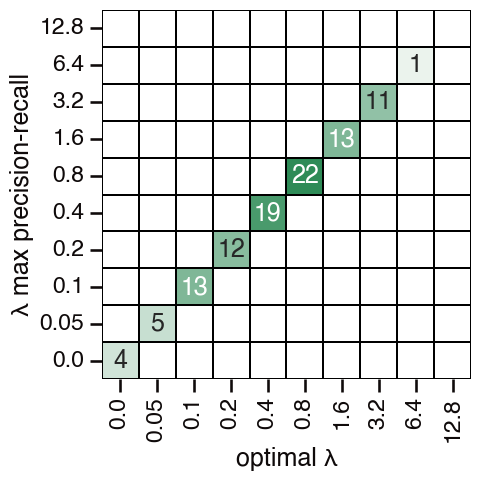

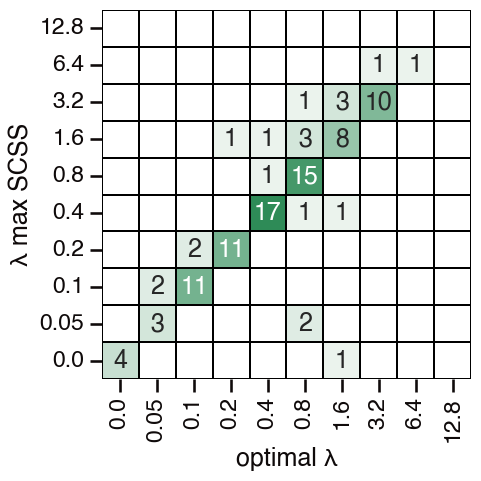

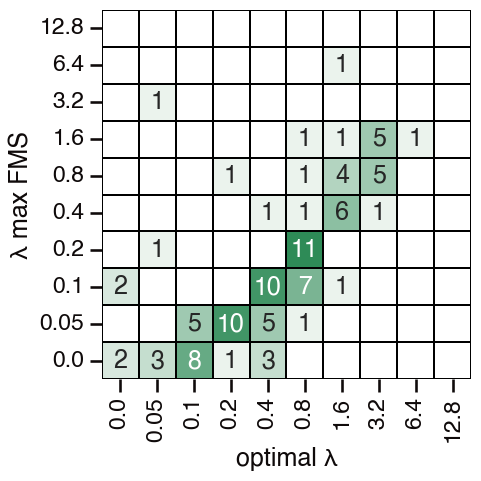

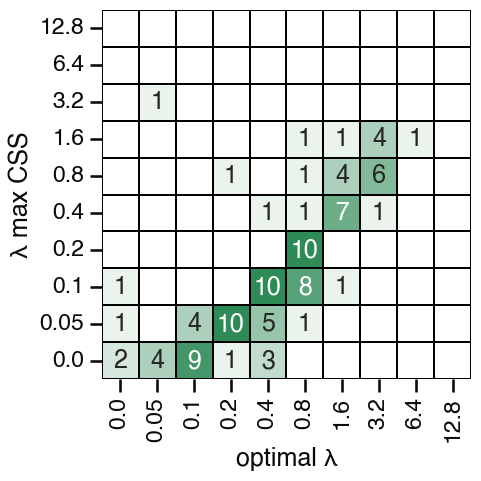

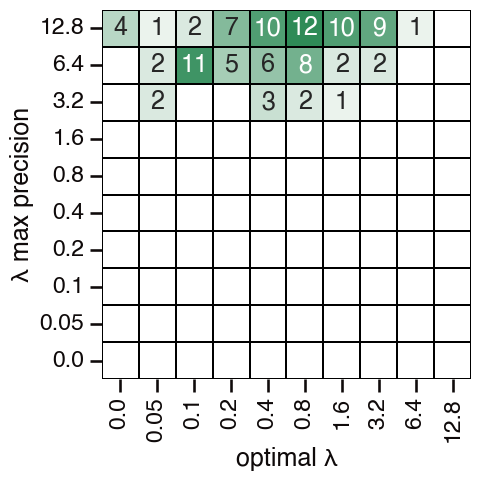

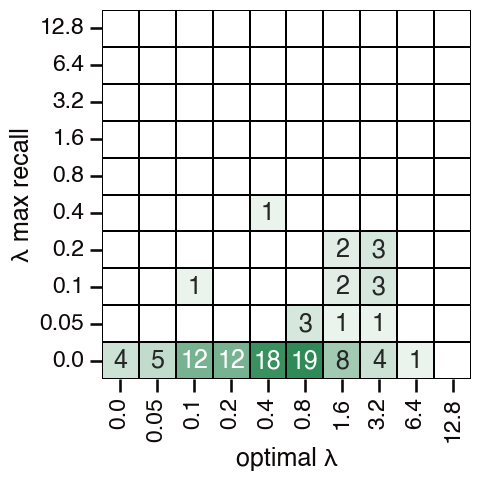

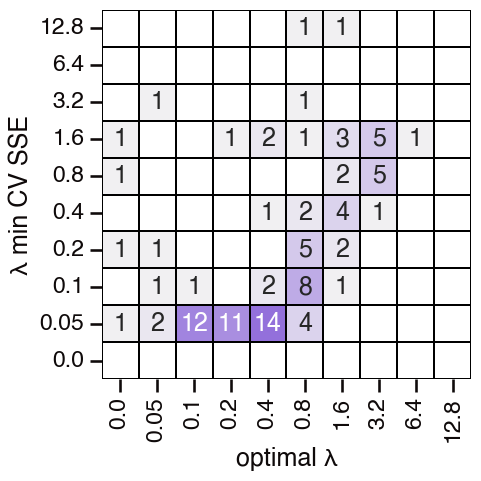

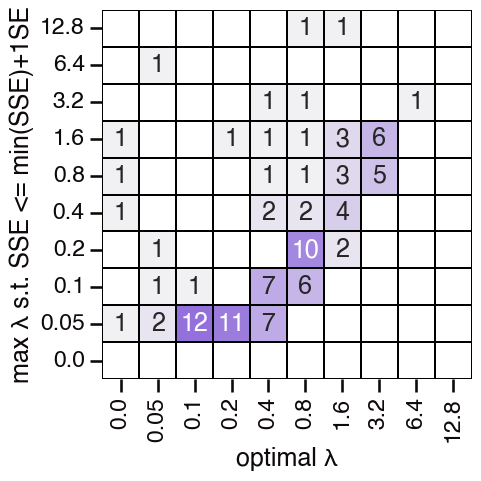

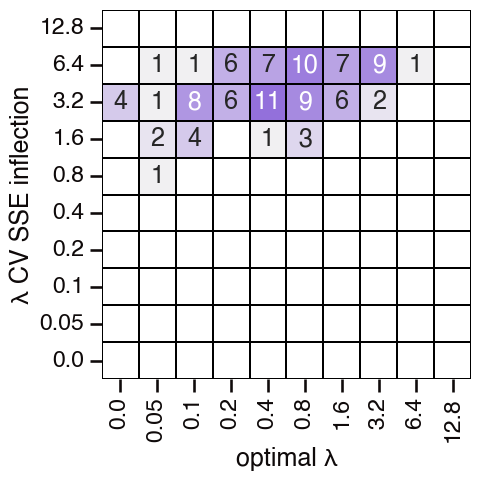

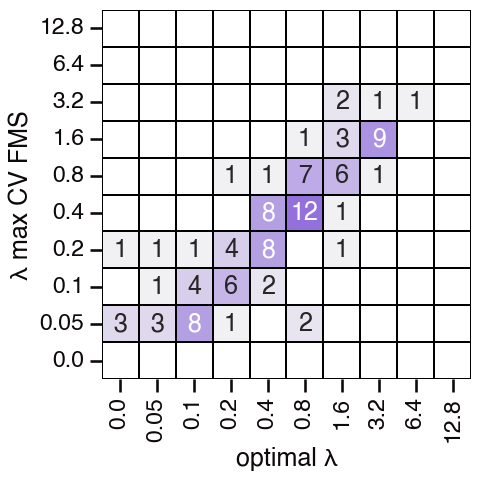

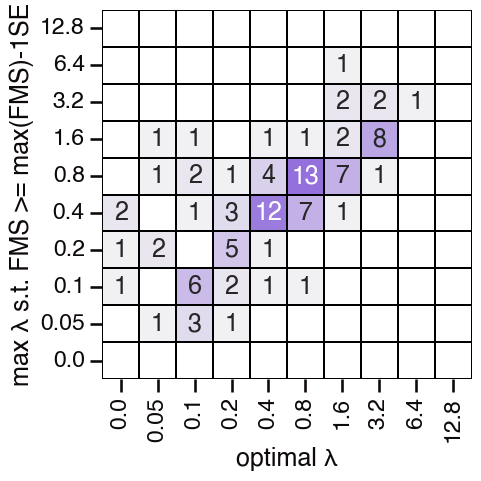

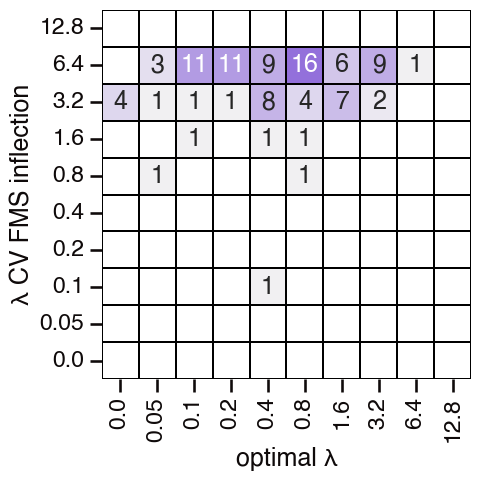

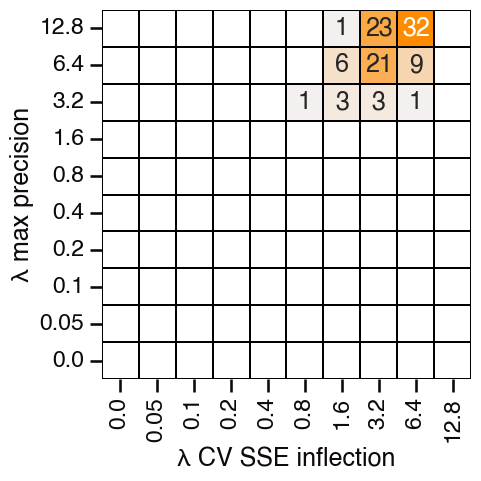

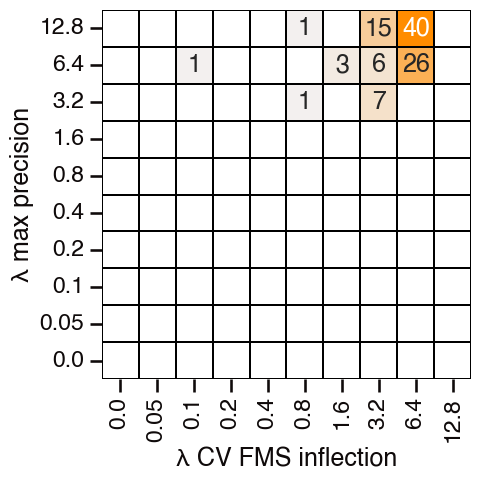

In [16]:
# make heatmap comparing optimal lambda values with methods of identification

# make template dataframe to house heatmap data
lambdas = results_df['lambda'].unique()
template_lambda_counts_df = pd.DataFrame(columns=lambdas, index=np.flip(lambdas)).fillna(0).astype(int)

# set up metrics to look at
comparison_values = [
    ('optimal_lambda', 'optimal λ', 'lambda_max_mprs', 'λ max precision-recall', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_scss_f0', 'λ max SCSS', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_fms', 'λ max FMS', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_css_f0', 'λ max CSS', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_precision', 'λ max precision', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_recall', 'λ max recall', 'gt'), 
    ('optimal_lambda', 'optimal λ', 'lambda_min_cv_sse', 'λ min CV SSE', 'cv'),     
    ('optimal_lambda', 'optimal λ', 'lambda_min_cv_sse_1se', 'max λ s.t. SSE <= min(SSE)+1SE', 'cv'),
    ('optimal_lambda', 'optimal λ', 'lambda_sse_inflection', 'λ CV SSE inflection', 'cv'),     
    ('optimal_lambda', 'optimal λ', 'lambda_max_cv_fms', 'λ max CV FMS', 'cv'), 
    ('optimal_lambda', 'optimal λ', 'lambda_max_cv_fms_1se', 'max λ s.t. FMS >= max(FMS)-1SE', 'cv'),
    ('optimal_lambda', 'optimal λ', 'lambda_fms_inflection', 'λ CV FMS inflection', 'cv'), 
    ('lambda_sse_inflection', 'λ CV SSE inflection', 'lambda_max_precision', 'λ max precision', 'other'), 
    ('lambda_fms_inflection', 'λ CV FMS inflection', 'lambda_max_precision', 'λ max precision', 'other')
]

# iterate through plots
for (col1, label1, col2, label2, dtype) in comparison_values:
    # arrange plot data
    plot_df = template_lambda_counts_df.copy()
    data_df = optimal_lambda_df[[col1, col2]].value_counts()
    for i, value in zip(data_df.index, data_df.values):
        plot_df.loc[i[1], i[0]] = value

    # set colormap based on datatype
    if dtype == 'gt':
        cmap = sns.color_palette('light:seagreen', as_cmap=True)
    elif dtype == 'cv':
        cmap = sns.color_palette('light:mediumpurple', as_cmap=True)
    else:
        cmap = sns.color_palette('light:darkorange', as_cmap=True)
        
    # make heatmap
    sns.heatmap(
        plot_df, 
        cmap=cmap, 
        annot=True, 
        linecolor='black', 
        linewidths=0.01, 
        cbar=False, 
        square=True, 
        mask=(plot_df == 0), 
    );
    plt.yticks(rotation=0)
    plt.xlabel(label1);
    plt.ylabel(label2);
#     plt.savefig('{}-v-{}.png'.format(col1, col2), bbox_inches='tight')
    plt.show()
    

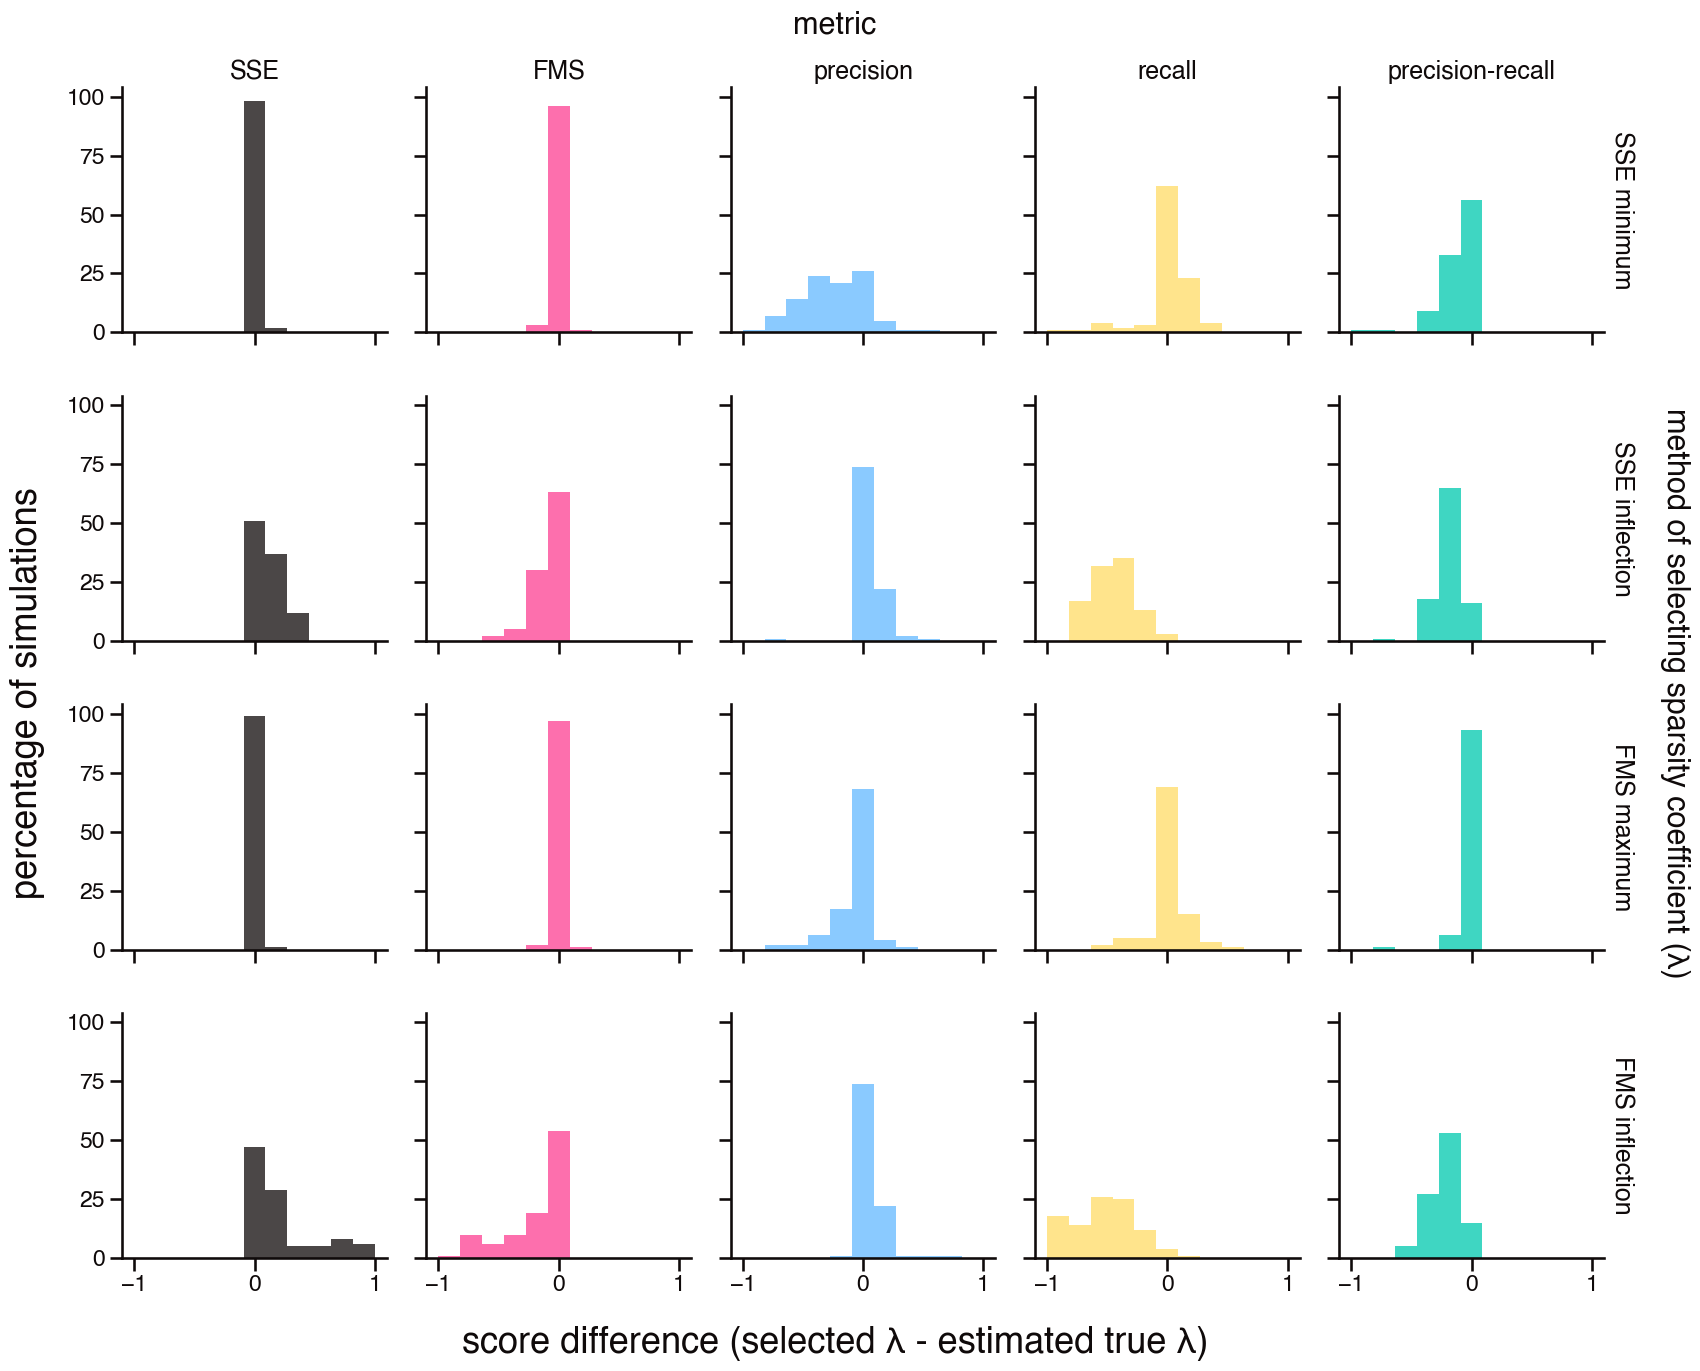

In [17]:
# look at difference between selected sparsity and optimal sparsity on a number of different metrics

# start with aggregated ground truth data
lambda_summary_df = gt_df_agg.copy()
# map back optimal rank and lambda, as well as noise
lambda_summary_df['optimal_rank'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
lambda_summary_df['optimal_lambda'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_lambda']
)
lambda_summary_df['noise_level'] = lambda_summary_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['noise_level']
)
# down-select to just optimal rank models
lambda_summary_df = lambda_summary_df[
    lambda_summary_df['rank'] == lambda_summary_df['optimal_rank']
].reset_index(drop=True)

# organize naming conventions for metrics
gt_metrics = ['gt_sse_mean', 'gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']
metrics = ['SSE', 'FMS', 'precision', 'recall', 'precision-recall']

# collect metrics 
gt_optimal_models_df = lambda_summary_df[
    lambda_summary_df['lambda'] == lambda_summary_df['optimal_lambda']
].reset_index(drop=True).rename(columns={
    k: f'{v}_optimal_lambda' for (k, v) in zip(gt_metrics, metrics)
}).drop(columns=['rank', 'lambda', 'optimal_rank', 'optimal_lambda', 'noise_level', 
                 'gt_recovery_mean', 'gt_relevance_mean', 'gt_recovery_relevance_mean'])

# add metrics for each method of selecting sparsity level
methods = [
#     'min_cv_sse', 
    'min_cv_sse_1se', 
    'sse_inflection', 
#     'max_cv_fms', 
    'max_cv_fms_1se', 
    'fms_inflection'
]

# compile methods comparison df
methods_comparison_df = pd.DataFrame()
for method in methods:
    working_df = lambda_summary_df.copy()
    # map method lambdas on working_df
    working_df['selected_lambda'] = working_df['simulation_id'].map(
        optimal_lambda_df.set_index('simulation_id')['lambda_{}'.format(method)]
    )
    # down-select to models with selected lambda
    working_df = working_df[working_df['lambda'] == working_df['selected_lambda']].rename(columns={
        k: f'{v}_selected_lambda' for (k, v) in zip(gt_metrics, metrics)
    })
    method_df = pd.merge(left=gt_optimal_models_df, right=working_df, on='simulation_id')
    # calculate differences
    for metric in metrics:
        method_df[metric] = method_df[f'{metric}_selected_lambda'] - method_df[f'{metric}_optimal_lambda']
    method_df['method'] = method
    if len(methods_comparison_df) == 0:
        methods_comparison_df = method_df
    else:
        methods_comparison_df = pd.concat([methods_comparison_df, method_df])

# melt methods comparison df for easy plotting
methods_comparison_df = methods_comparison_df.melt(
    id_vars=['simulation_id', 'method'], value_vars=metrics, var_name='metric'
)
# map method label for informative margin labels
methods_comparison_df['method'] = methods_comparison_df['method'].map({
    'min_cv_sse_1se': 'SSE minimum', 
    'sse_inflection': 'SSE inflection', 
    'max_cv_fms_1se': 'FMS maximum', 
    'fms_inflection': 'FMS inflection'
})
    
g = sns.FacetGrid(
    methods_comparison_df, 
    row='method', col='metric', hue='metric', 
    palette=sns.color_palette([accent_colors[i] for i in [4, 3, 7, 6, 2]]), 
    margin_titles=True,
    height=3.3
)
g.map(sns.histplot, 'value', bins=11, binrange=(-1, 1));
g.set_titles(row_template='{row_name}', col_template='{col_name}');
g.set_axis_labels('', '')
g.fig.text(.5, 0, ha='center', s='score difference (selected λ - estimated true λ)', fontdict={'fontsize':26});
g.fig.text(0, .5, rotation=90, va='center', s='percentage of simulations', fontdict={'fontsize':26});
g.fig.text(.5, 1, ha='center', s='metric', fontdict={'fontsize':22});
g.fig.text(
    1, .5, rotation=270, va='center', s='method of selecting sparsity coefficient (λ)', fontdict={'fontsize':22}
);

g.savefig('sparsity-selection-method-comparison.png', bbox_inches='tight')
    

# Sparsity coefficient selection evaluation
- How close does FMS maximum get us to the optimal lambda?
- NOTE: 5 data points in which the optimal lambda was 0 were removed for ease of plotting.
    - 4/5 of these had a sparsity less than 0.08, and the fifth had a sparsity of 0.28 with a noise:signal ratio of 9.7


/Users/blasks/Library/Caches/pypoetry/virtualenvs/stromatolite-paper-AG5eZpWO-py3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


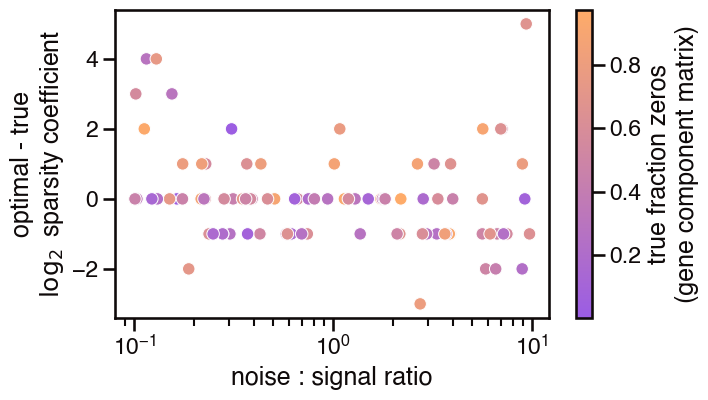

In [18]:
# plot true rank vs. optimal rank

# arrange data for plotting
lambda_plot_df = simulation_info_df.copy()
lambda_plot_df['lambda_max_cv_fms_1se'] = lambda_plot_df['simulation_id'].map(
    optimal_lambda_df.set_index('simulation_id')['lambda_max_cv_fms_1se']
)
lambda_plot_df['log_lambda_difference'] = np.log2(lambda_plot_df['lambda_max_cv_fms_1se']) - np.log2(lambda_plot_df['optimal_lambda'])
# lambda_plot_df = lambda_plot_df.sort_values(['simulation_rank', 'noise_level']).reset_index(drop=True)
lambda_plot_df['true sparsity'] = 1 - lambda_plot_df['factor0_density']

# create plot
fig_b, ax_b = plt.subplots(figsize=[7, 4])
sns.scatterplot(
    x='noise_level', 
    y='log_lambda_difference', 
    hue='true sparsity', 
    palette=grad_cmap, 
    alpha=1.0, 
    data=lambda_plot_df, 
    ax=ax_b
)
plt.xlabel('noise : signal ratio');
plt.ylabel('optimal - true\n$\log_2$ sparsity coefficient');
plt.xscale('log')
# make a colorbar for the markers and replace the default legend with that
norm = plt.Normalize(lambda_plot_df['true sparsity'].min(), lambda_plot_df['true sparsity'].max())
sm = plt.cm.ScalarMappable(cmap=grad_cmap, norm=norm)
sm.set_array([])
ax_b.get_legend().remove()
ax_b.figure.colorbar(sm, ax=ax_b, label='true fraction zeros\n(gene component matrix)');

# plt.savefig('optimal_rank_v_noise.png', bbox_inches='tight')


In [19]:
# look at simulations in which optimal lambda is zero

lambda_plot_df[lambda_plot_df['log_lambda_difference'] == np.inf]


,simulation_id,simulation_rank,simulation_shape,simulation_mean_gene_sparsity,noise_level,mode0_length,mode1_length,mode2_length,factor0_density,factor1_density,factor2_density,optimal_rank,optimal_lambda,lambda_max_cv_fms_1se,log_lambda_difference,true sparsity
57,57,8,"(156, 65, 69)",146.997880,7.315406,156,65,69,0.942294,0.289325,0.176497,6,0.0,0.4,inf,0.057706
77,77,5,"(465, 21, 39)",446.220759,4.965859,465,21,39,0.959615,0.492751,0.708791,5,0.0,0.2,inf,0.040385
87,87,6,"(466, 38, 33)",448.992994,2.048630,466,38,33,0.963504,0.698346,0.947308,6,0.0,0.4,inf,0.036496
95,95,9,"(374, 89, 83)",373.187824,0.152412,374,89,83,0.997828,0.347656,0.122075,9,0.0,0.1,inf,0.002172


# Lambda robustness to mis-specification
How off are different metrics when a sub-optimal lambda value is used?
    

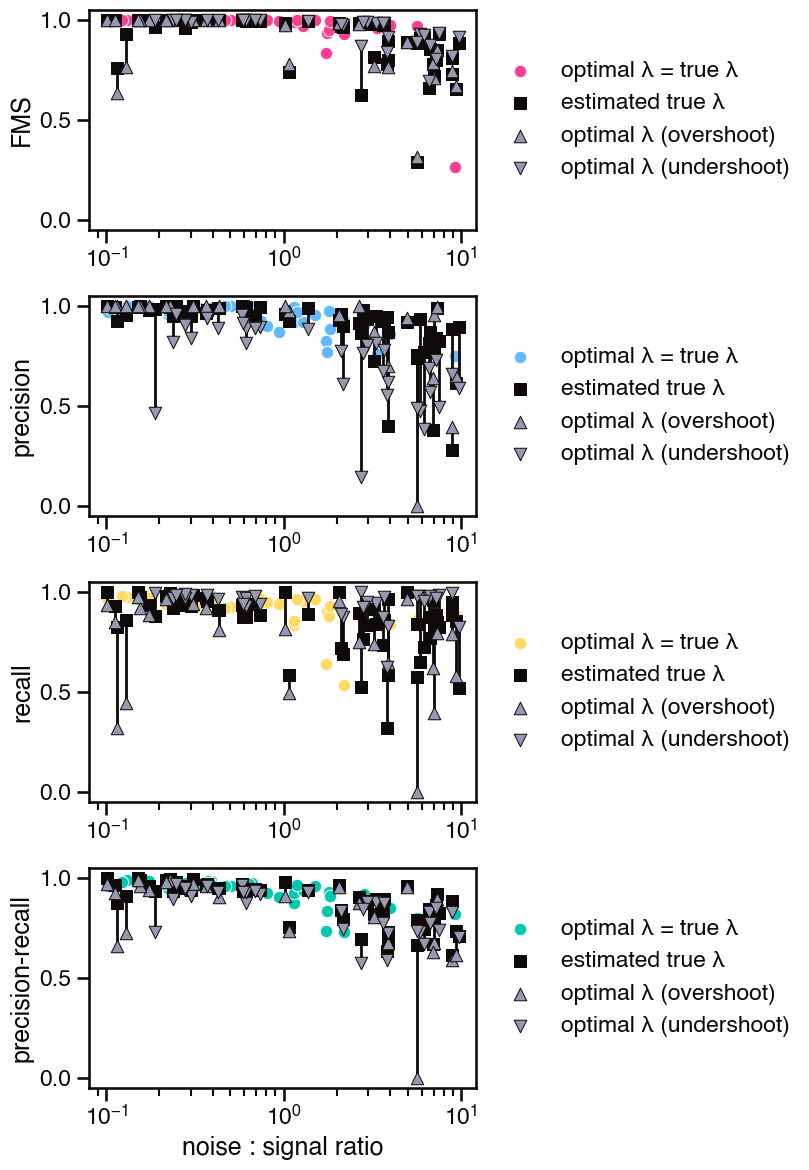

In [20]:
# plot metric differences of models parameterized with best fit and optimal lambda values

# make figure panel
fig = plt.figure(figsize=(5, 14))
gs = plt.GridSpec(4, 1, figure=fig, hspace=.3)

# set up data
robust_lambda_df = lambda_summary_df.copy()
robust_lambda_df['best_fit_lambda'] = robust_lambda_df['simulation_id'].map(
    optimal_lambda_df.set_index('simulation_id')['lambda_max_cv_fms_1se']
)
robust_lambda_df['comparison'] = 'match'
robust_lambda_df.loc[
    (robust_lambda_df['best_fit_lambda'] > robust_lambda_df['optimal_lambda']), 'comparison'] = 'overshoot'
robust_lambda_df.loc[
    (robust_lambda_df['best_fit_lambda'] < robust_lambda_df['optimal_lambda']), 'comparison'] = 'undershoot'

# set colors and labels
colors = {
    'gt_fms_mean': accent_colors[3], 
    'gt_precision_mean': accent_colors[7], 
    'gt_recall_mean': accent_colors[6], 
    'gt_precision_recall_mean': accent_colors[2], 
}
labels = {
    'gt_fms_mean': 'FMS', 
    'gt_precision_mean': 'precision', 
    'gt_recall_mean': 'recall', 
    'gt_precision_recall_mean': 'precision-recall', 
}

# plot each metric
for i, metric in enumerate(['gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']):
    # make new axis
    axis = fig.add_subplot(gs[i, 0])
    # plot points where best fit matches optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'match']
    data_df = data_df[data_df['lambda'] == data_df['optimal_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='optimal λ = true λ', data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit lambda does not fit optimal lambda
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['lambda'] == data_df['optimal_lambda']][metric], 
        data_df[data_df['lambda'] == data_df['best_fit_lambda']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of optimal lambda where best fit lambda doesn't match
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    data_df = data_df[data_df['lambda'] == data_df['optimal_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='estimated true λ', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it overshoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['lambda'] == data_df['best_fit_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='optimal λ (overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it undershoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['lambda'] == data_df['best_fit_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='optimal λ (undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='noise : signal ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


# Rank robustness to mis-specification

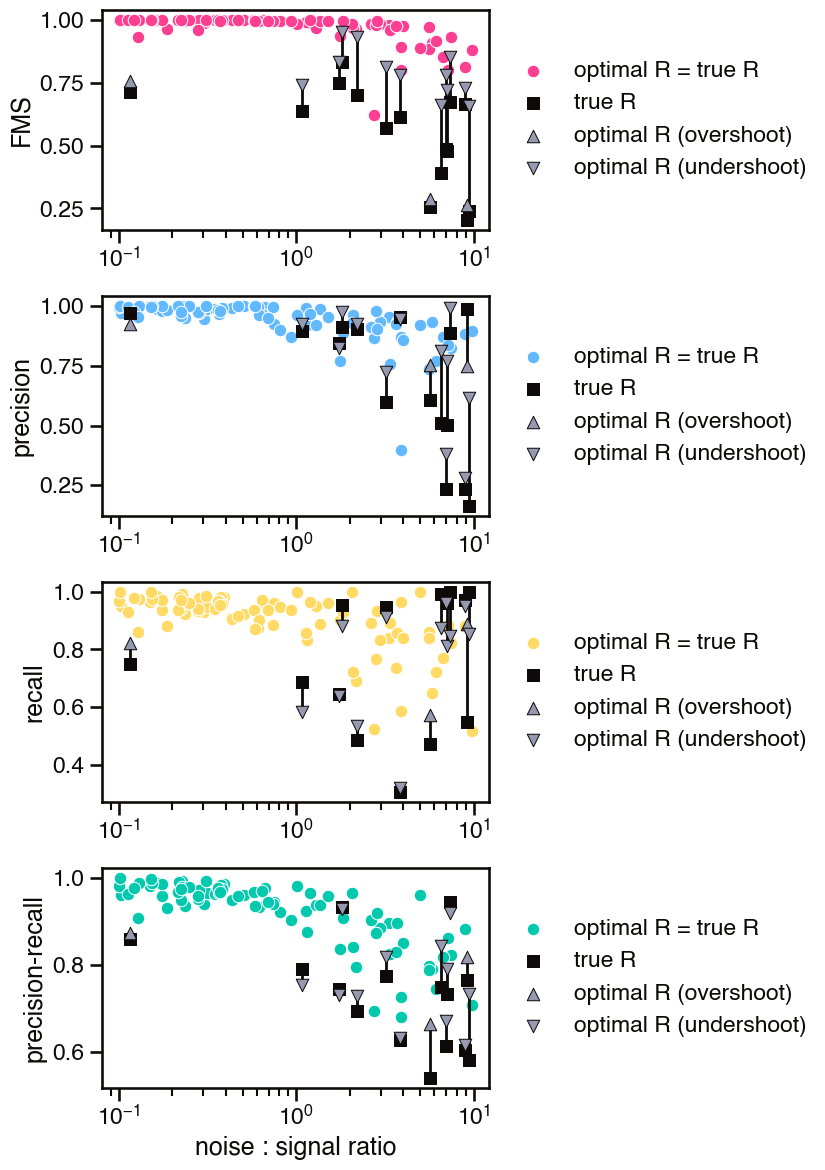

In [21]:
# compare scores of optimal and suboptimal rank values

# make figure panel
fig = plt.figure(figsize=(5, 14))
gs = plt.GridSpec(4, 1, figure=fig, hspace=.3)

# set up data
robust_rank_df = gt_df_agg.copy()
robust_rank_df['true_rank'] = robust_rank_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['simulation_rank']
)
robust_rank_df['best_fit_rank'] = robust_rank_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_rank']
)
robust_rank_df['optimal_lambda'] = robust_rank_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['optimal_lambda']
)
robust_rank_df['best_fit_lambda'] = robust_rank_df['simulation_id'].map(
    optimal_lambda_df.set_index('simulation_id')['lambda_max_cv_fms_1se']
)
robust_rank_df['noise_level'] = robust_rank_df['simulation_id'].map(
    simulation_info_df.set_index('simulation_id')['noise_level']
)
robust_rank_df['comparison'] = 'match'
robust_rank_df.loc[
    (robust_rank_df['best_fit_rank'] < robust_rank_df['true_rank']), 'comparison'] = 'undershoot'
robust_rank_df.loc[
    (robust_rank_df['best_fit_rank'] > robust_rank_df['true_rank']), 'comparison'] = 'overshoot'
robust_rank_df = robust_rank_df[robust_rank_df['lambda'] == robust_rank_df['optimal_lambda']]

# plot each metric
for i, metric in enumerate(['gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']):
    # make new axis
    axis = fig.add_subplot(gs[i, 0])
    # plot points where best fit matches true
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'match']
    data_df = data_df[data_df['rank'] == data_df['true_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='optimal R = true R', 
        data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit rank does not fit optimal rank
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['rank'] == data_df['true_rank']][metric], 
        data_df[data_df['rank'] == data_df['best_fit_rank']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of true rank where best fit rank doesn't match
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    data_df = data_df[data_df['rank'] == data_df['true_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='true R', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it overshoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['rank'] == data_df['best_fit_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='optimal R (overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it undershoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['rank'] == data_df['best_fit_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='optimal R (undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='noise : signal ratio', xscale='log')
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log')
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


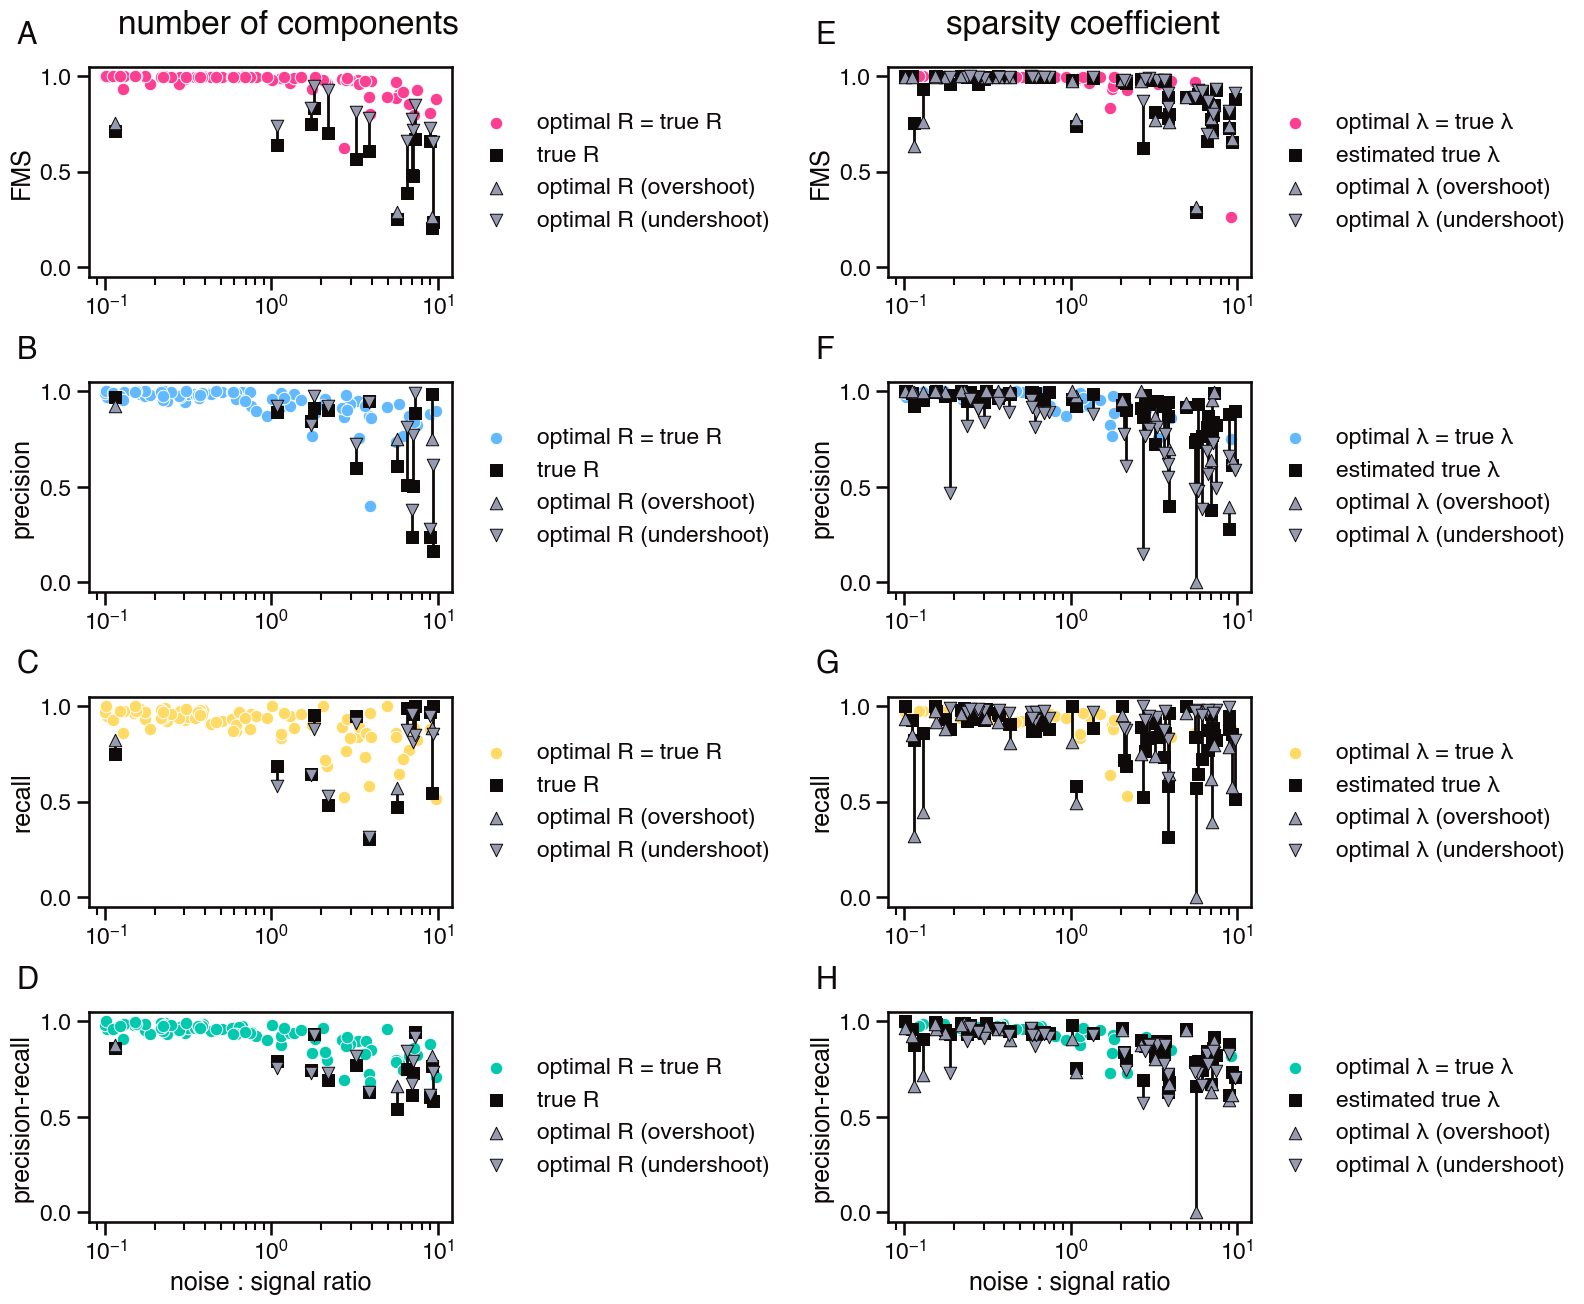

In [22]:
# panel figure: combine rank and lambda data

# make figure panel
fig = plt.figure(figsize=(15, 15))
gs = plt.GridSpec(4, 2, figure=fig, hspace=.5, wspace=1.2)


# rank robustness to misspecification
for i, metric in enumerate(['gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']):
    # make new axis
    axis = fig.add_subplot(gs[i, 0])
    axis.annotate({0: 'A', 1: 'B', 2: 'C', 3: 'D'}[i], xy=(-0.2, 1.15), **annot_kwgs)
    if not i:
        axis.annotate('number of components', xy=(0.08, 1.2), xycoords='axes fraction', va='center', ha='left',
                      fontsize=24, annotation_clip=False)
    # plot points where best fit matches true
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'match']
    data_df = data_df[data_df['rank'] == data_df['true_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='optimal R = true R', 
        data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit rank does not fit optimal rank
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['rank'] == data_df['true_rank']][metric], 
        data_df[data_df['rank'] == data_df['best_fit_rank']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of true rank where best fit rank doesn't match
    data_df = robust_rank_df[robust_rank_df['comparison'] != 'match']
    data_df = data_df[data_df['rank'] == data_df['true_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='true R', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it overshoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['rank'] == data_df['best_fit_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='optimal R (overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit rank where it undershoots optimal
    data_df = robust_rank_df[robust_rank_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['rank'] == data_df['best_fit_rank']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='optimal R (undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='noise : signal ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# lambda robustness to misspecification
for i, metric in enumerate(['gt_fms_mean', 'gt_precision_mean', 'gt_recall_mean', 'gt_precision_recall_mean']):
    # make new axis
    axis = fig.add_subplot(gs[i, 1])
    axis.annotate({0: 'E', 1: 'F', 2: 'G', 3: 'H'}[i], xy=(-0.2, 1.15), **annot_kwgs)
    if not i:
        axis.annotate('sparsity coefficient', xy=(0.16, 1.2), xycoords='axes fraction', va='center', ha='left',
                      fontsize=24, annotation_clip=False)
    # plot points where best fit matches optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'match']
    data_df = data_df[data_df['lambda'] == data_df['optimal_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=colors[metric], label='optimal λ = true λ', data=data_df, ax=axis
    )
    # plot lines showing metric score differences where best fit lambda does not fit optimal lambda
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    metric_pairs = pd.DataFrame(zip(
        data_df[data_df['lambda'] == data_df['optimal_lambda']][metric], 
        data_df[data_df['lambda'] == data_df['best_fit_lambda']][metric]
    ))
    axis.vlines(
        x=data_df[['simulation_id', 'noise_level']].drop_duplicates()['noise_level'], 
        ymin=metric_pairs.min(axis=1), ymax=metric_pairs.max(axis=1), color=line_color, zorder=1
    )
    # plot metric score of optimal lambda where best fit lambda doesn't match
    data_df = robust_lambda_df[robust_lambda_df['comparison'] != 'match']
    data_df = data_df[data_df['lambda'] == data_df['optimal_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=line_color, marker='s', edgecolor=None, label='estimated true λ', 
        data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it overshoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'overshoot']
    data_df = data_df[data_df['lambda'] == data_df['best_fit_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='^', edgecolor=line_color, 
        label='optimal λ (overshoot)', data=data_df, ax=axis
    )
    # plot metric score of best fit lambda where it undershoots optimal
    data_df = robust_lambda_df[robust_lambda_df['comparison'] == 'undershoot']
    data_df = data_df[data_df['lambda'] == data_df['best_fit_lambda']]
    sns.scatterplot(
        x='noise_level', y=metric, color=accent_colors[5], marker='v', edgecolor=line_color, 
        label='optimal λ (undershoot)', data=data_df, ax=axis
    )
    # fix labels
    if i == 3:
        axis.set(ylabel=labels[metric], xlabel='noise : signal ratio', xscale='log', ylim=[-0.05, 1.05])
    else:
        axis.set(ylabel=labels[metric], xlabel='', xscale='log', ylim=[-0.05, 1.05])
    axis.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
fig.savefig('robustness-to-misspecification.png', bbox_inches='tight')


# Parameter selection workflow validation figure

Main text figure to show the results of testing the parameter gridsearch workflow using 100 simulated data tensors


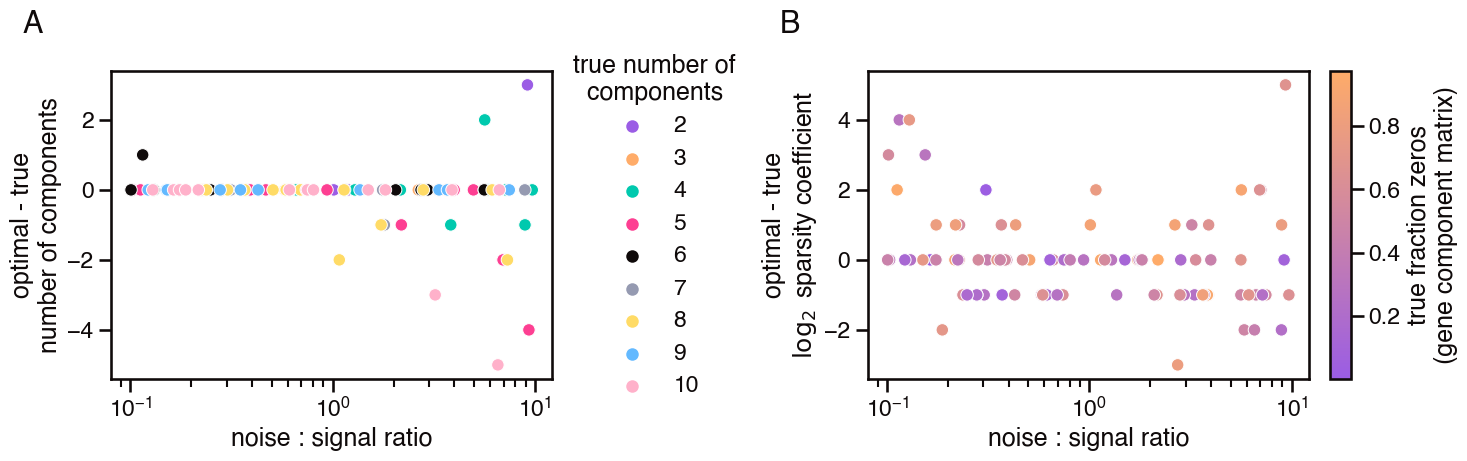

In [23]:
# plot metric differences of models parameterized with best fit and optimal lambda values

# make figure panel
fig = plt.figure(figsize=(16, 4))
gs = plt.GridSpec(1, 30, wspace=1, figure=fig)

# plot true rank vs. optimal rank
ax_a = fig.add_subplot(gs[0, 0:11])
ax_a.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)
sns.scatterplot(
    x='noise_level', 
    y='best fit rank - true rank', 
    hue='simulation_rank', 
    alpha=1.0, 
    data=rank_plot_df, 
    ax=ax_a
)
ax_a.set(xlabel='noise : signal ratio', ylabel='optimal - true\nnumber of components', xscale='log')
ax_a.legend(title='true number of\n  components', loc='center left', bbox_to_anchor=[1, .5]);


# plot lambda validation
ax_b = fig.add_subplot(gs[0, 18:29])
ax_b.annotate('B', xy=(-0.2, 1.15), **annot_kwgs)
sns.scatterplot(
    x='noise_level', 
    y='log_lambda_difference', 
    hue='true sparsity', 
    palette=grad_cmap, 
    alpha=1.0, 
    data=lambda_plot_df, 
    ax=ax_b
)
ax_b.set(xlabel='noise : signal ratio', ylabel='optimal - true\n$\log_2$ sparsity coefficient', xscale='log')
# make a colorbar for the markers and replace the default legend with that
norm = plt.Normalize(lambda_plot_df['true sparsity'].min(), lambda_plot_df['true sparsity'].max())
sm = plt.cm.ScalarMappable(cmap=grad_cmap, norm=norm)
sm.set_array([])
ax_b.get_legend().remove()
ax_b.figure.colorbar(sm, cax=fig.add_subplot(gs[0, 29]), 
                     label='true fraction zeros\n(gene component matrix)', aspect=20);

plt.savefig('cv-parameterization-validation.png', bbox_inches='tight')


In [24]:
# calculate stats

param_summary_df = lambda_plot_df.join(rank_plot_df.set_index('simulation_id')['best fit rank - true rank'], 
                                       on='simulation_id')

print('Correct rank parameter:')
print(param_summary_df['best fit rank - true rank'].eq(0).value_counts())

print('Rank off by one or less:')
print(np.abs(param_summary_df['best fit rank - true rank']).le(1).value_counts())

print('Correct lambda parameter:')
print(param_summary_df['log_lambda_difference'].eq(0).value_counts())

print('Lambda parameter off by power of 2 or less:')
print(np.abs(param_summary_df['log_lambda_difference']).le(1).value_counts())

print('Both rank and lambda match:')
print((param_summary_df['best fit rank - true rank'].eq(0) & 
       param_summary_df['log_lambda_difference'].eq(0)).value_counts())

print('Both rank and lambda within one unit:')
print((np.abs(param_summary_df['best fit rank - true rank']).le(1) & 
       np.abs(param_summary_df['log_lambda_difference']).le(1)).value_counts())

print('Simulations with noise:signal less than 1:')
print(param_summary_df['noise_level'].lt(5).value_counts())

print('Lambda undershoot:')
print(param_summary_df['log_lambda_difference'].lt(0).value_counts())

print('Lambda overshoot:')
print(param_summary_df['log_lambda_difference'].gt(0).value_counts())

print('Lambda undershoot:')
print(param_summary_df['log_lambda_difference'].eq(0).value_counts())

print('Mean R miss above noise:signal of 1:')
r_misses = param_summary_df[~param_summary_df['best fit rank - true rank'].eq(0)]
print(np.abs(r_misses[r_misses['noise_level'].gt(1)]['best fit rank - true rank']).mean())

lamb_misses = param_summary_df[~param_summary_df['log_lambda_difference'].eq(0)]
lamb_misses = lamb_misses[~(param_summary_df['log_lambda_difference'] == np.inf)]
print('Mean lambda miss below noise:signal of 1:')
print(np.abs(lamb_misses[lamb_misses['noise_level'].lt(1)].log_lambda_difference).mean())
print('Mean lambda miss above noise:signal of 1:')
print(np.abs(lamb_misses[lamb_misses['noise_level'].gt(1)].log_lambda_difference).mean())


Correct rank parameter:
True     85
False    15
Name: best fit rank - true rank, dtype: int64
Rank off by one or less:
True     91
False     9
Name: best fit rank - true rank, dtype: int64
Correct lambda parameter:
False    59
True     41
Name: log_lambda_difference, dtype: int64
Lambda parameter off by power of 2 or less:
True     77
False    23
Name: log_lambda_difference, dtype: int64
Both rank and lambda match:
False    63
True     37
dtype: int64
Both rank and lambda within one unit:
True     75
False    25
dtype: int64
Simulations with noise:signal less than 1:
True     83
False    17
Name: noise_level, dtype: int64
Lambda undershoot:
False    66
True     34
Name: log_lambda_difference, dtype: int64
Lambda overshoot:
False    75
True     25
Name: log_lambda_difference, dtype: int64
Lambda undershoot:
False    59
True     41
Name: log_lambda_difference, dtype: int64
Mean R miss above noise:signal of 1:
2.142857142857143
Mean lambda miss below noise:signal of 1:
1.52
Mean lambda mi

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_87713/2581711697.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lamb_misses = lamb_misses[~(param_summary_df['log_lambda_difference'] == np.inf)]
